<a href="https://colab.research.google.com/github/Wukkkinz-0725/EECS6893_Project/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('drive/MyDrive/NFT_prediction_project/final_data')

In [4]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=685ff9d509d3734bea1ff18dc7adb49c46b1e2835715e6d7b82aec678735681c
  Stored in directory: /root/.cache/pip/wheels/ac/13/2d/3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from keras.models import Sequential
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, LSTM, Dropout, Attention, Bidirectional, Flatten
from keras.regularizers import L1L2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [28]:
def LSTM_baseline(X_train, y_train, epoch, train_cols=1, verbose=0):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], train_cols)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error') # Adam is generally chosen as the best overall choice
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=verbose)
    return model

In [98]:
def LSTM_attention(X_train, y_train, epoch, train_cols=1, verbose=0):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], train_cols)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=verbose)
    return model

In [97]:
def LSTM_bidirection(X_train, y_train, epoch, train_cols=1, verbose=0):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], train_cols)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=verbose)
    return model

In [114]:
def plot_real_pred_compare(real_price, pred_price, label, model_type, train_interval, cols=None):
    fig = plt.figure()
    plt.plot(real_price, color='black', label='Real Price')
    plt.plot(pred_price, color='green', label='Predicted Price')
    title = '{} with model={}, interval={}'.format(label, model_type, train_interval)
    if cols:
        cols_str = ', '.join([col for col in cols])
        title = title + '\n cols=[{}]'.format(cols_str)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel(label + ' NFT Price')
    plt.legend()
    return fig

In [111]:
def training_and_plot(nft_label, train_interval, model_type, epoch):
    data = pd.read_csv(nft_label + '.csv', index_col=0)['Average USD'].values.reshape(-1,1)
    # scale the data to [0,1]
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = sc.fit_transform(data)

    # split 70% for training, 30% for testing
    data_size = len(data)
    train_size = int(data_size * 0.7)
    test_size = data_size - train_size
    train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:len(data)]

    # generate training data
    X_train = np.array([train_data[i:i+train_interval] for i in range(len(train_data)-train_interval)]) 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    y_train = np.array([train_data[i+train_interval] for i in range(len(train_data)-train_interval)])

    model = None
    
    if model_type == 'baseline':
        model = LSTM_baseline(X_train, y_train, epoch)
    elif model_type == 'attention':
        model = LSTM_attention(X_train, y_train, epoch)
    elif model_type == 'bidirection':
        model = LSTM_bidirection(X_train, y_train, epoch)
    model.save('models/{}_{}_{}.h5'.format(nft_label, model_type, train_interval))
    real_price = data[data_size-test_size:]
    inputs = data[data_size - test_size - train_interval:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    X_test = [inputs[i - train_interval:i, 0] for i in range(train_interval, test_size + train_interval)]

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    pred_price = model.predict(X_test)
    pred_price = sc.inverse_transform(pred_price)

    fig = plot_real_pred_compare(real_price, pred_price, nft_label, model_type, train_interval)
    return {'model': model, 'pred_price': pred_price, 'real_price': real_price, 'fig': fig}

In [116]:
def training_and_plot_multi_cols(nft_label, train_interval, model_type, cols, epoch=100):
    col_size = len(cols)
    data = pd.read_csv(nft_label + '.csv', index_col=0)[cols].values.reshape(-1, col_size)
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = sc.fit_transform(data)
    data_size = len(data)
    train_size = int(data_size * 0.7)
    test_size = data_size - train_size
    train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:len(data)]

    train_interval = 30
    X_train = np.array([train_data[i:i+train_interval] for i in range(len(train_data)-train_interval)]) 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], col_size))

    sc_target = MinMaxScaler(feature_range=(0, 1))
    target_data = pd.read_csv(nft_label + '.csv', index_col=0)['Average USD'].values.reshape(-1,1)
    target_scaled = sc_target.fit_transform(target_data)

    y_train = np.array([target_scaled[i+train_interval] for i in range(len(train_data)-train_interval)])

    model = None
    
    if model_type == 'baseline':
        model = LSTM_baseline(X_train, y_train, epoch, col_size)
    elif model_type == 'attention':
        model = LSTM_attention(X_train, y_train, epoch, col_size)
    elif model_type == 'bidirection':
        model = LSTM_bidirection(X_train, y_train, epoch, col_size)
    model.save('models_/{}_{}_{}.h5'.format(nft_label, model_type, train_interval))
    real_price = target_data[data_size-test_size:]
    inputs = data[data_size - test_size - train_interval:]
    inputs = inputs.reshape(-1, col_size)
    inputs = sc.transform(inputs)

    X_test = [inputs[i - train_interval:i] for i in range(train_interval, test_size + train_interval)]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], col_size))
    pred_price = model.predict(X_test)
    pred_price = sc_target.inverse_transform(pred_price)

    fig = plot_real_pred_compare(real_price, pred_price, nft_label, 'baseline', train_interval, cols)
    return {'model': model, 'pred_price': pred_price, 'real_price': real_price, 'cols': cols, 'fig': fig}


16/16 [==============================] - 2s 8ms/step


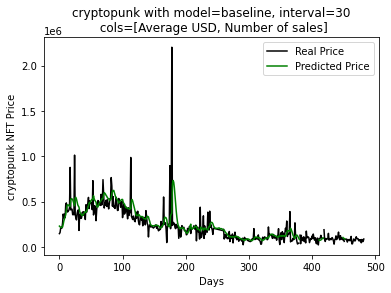

In [117]:
retval = training_and_plot_multi_cols('cryptopunk', 30, 'bidirection', ['Average USD', 'Number of sales'])

In [109]:
retval['fig'].savefig

AttributeError: ignored

In [10]:
# we assume default epoch is 100, since epoch=100 could have a good performance
epoch = 100
nfts = ['cryptopunk', 'artblocks', 'bayc']
model_type = ['baseline', 'attention', 'bidirection']
train_intervals = [30, 60, 90]

results = {}


def train_all():
    for nft in nfts:
        results[nft] = {}
        for model in model_type:
            results[nft][model] = {}
            for interval in train_intervals:
                results[nft][model][interval] = training_and_plot(nft_label=nft, train_interval=interval, model_type=model, epoch=epoch)

# train_all()

In [ ]:
import sklearn.metrics as metrics

standard_metrics = pd.Series()
standard_metrics.loc['MAE'] = metrics.mean_absolute_error(real_price_1, pred_price_1)
standard_metrics.loc['MSE'] = metrics.mean_squared_error(real_price_2, pred_price_2)
standard_metrics.loc['MedAE'] = metrics.median_absolute_error(real_price_3, real_price_3)

print("Metrics for basic LSTM")
print(standard_metrics)


<ipython-input-39-503625f187c3>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  standard_metrics = pd.Series()


ValueError: ignored

In [ ]:
print(pred_price_1)

[[ 59069.754]
 [ 56676.48 ]
 [ 55169.26 ]
 [ 54570.36 ]
 [ 55486.75 ]
 [ 61496.47 ]
 [ 66930.7  ]
 [ 69773.9  ]
 [ 71712.055]
 [ 74981.6  ]
 [ 79288.68 ]
 [ 81799.77 ]
 [ 83293.92 ]
 [ 86736.64 ]
 [ 89980.39 ]
 [ 91000.23 ]
 [ 94768.31 ]
 [ 97473.445]
 [100054.77 ]
 [ 99406.13 ]
 [ 97322.4  ]
 [ 92350.484]
 [ 88063.945]
 [ 84641.43 ]
 [ 80232.36 ]
 [ 75875.83 ]
 [ 86500.5  ]
 [ 91579.55 ]
 [ 89155.24 ]
 [ 83158.22 ]
 [ 75324.94 ]
 [ 69746.75 ]
 [ 70189.97 ]
 [ 69876.24 ]
 [ 68348.945]
 [ 65604.28 ]
 [ 62800.734]
 [ 61631.598]
 [ 62342.73 ]
 [ 61724.043]
 [ 59977.504]
 [ 56690.12 ]
 [ 54127.36 ]
 [ 52198.645]
 [ 50464.918]
 [ 48890.01 ]
 [ 49443.055]
 [ 50411.16 ]
 [ 49703.457]
 [ 48142.207]
 [ 46518.355]
 [ 45656.53 ]
 [ 44801.23 ]
 [ 45833.414]
 [ 46639.812]
 [ 49473.723]
 [ 51319.965]
 [ 50336.12 ]
 [ 47164.324]
 [ 43681.63 ]
 [ 40093.555]
 [ 37907.605]
 [ 36422.15 ]
 [ 35464.984]
 [ 35136.76 ]
 [ 35238.17 ]
 [ 35029.63 ]
 [ 35227.223]
 [ 33791.15 ]
 [ 32562.402]
 [ 31534.762]
 [ 300

In [ ]:
def mean_squared_error(real_price, pred_price):
  squared_error = np.square(real_price - pred_price) 
  sum_squared_error = np.sum(squared_error)
  mse_loss = sum_squared_error / real_price.size
  return mse_loss

In [ ]:
lstm_mse = mean_squared_error(real_price_1, pred_price_1)
bi_lstm_mse = mean_squared_error(real_price_2, pred_price_2)
lstm_attention_mse = mean_squared_error(real_price_3, pred_price_3)

print(f"Mean squared error for LSTM: ", lstm_mse)
print(f"Mean squared error for Bi-LSTM: ", bi_lstm_mse)
print(f"Mean squared error for LSTM with attention: ", lstm_attention_mse)

In [ ]:
def mean_abs_error(real_price, pred_price):
  abs_error = np.absolute(real_price - pred_price) 
  sum_abs_error = np.sum(abs_error)
  mae_loss = sum_abs_error / real_price.size
  return mae_loss

In [ ]:
lstm_mae = mean_abs_error(real_price_1, pred_price_1)
bi_lstm_mae = mean_abs_error(real_price_2, pred_price_2)
lstm_attention_mae = mean_abs_error(real_price_3, pred_price_3)

print(f"Mean absolute error for LSTM: ", lstm_mae)
print(f"Mean absolute error for Bi-LSTM: ", bi_lstm_mae)
print(f"Mean absolute error for LSTM with attention: ", lstm_attention_mae)

In [ ]:
def binary_accuracy(real_price, pred_price):
  right_pred_count = 0
  for i in range(1, len(real_price)):
    if(real_price[i] > real_price[i-1] and pred_price[i] > real_price[i-1]) or (real_price[i] < real_price[i-1] and pred_price[i] < real_price[i-1]) or (real_price[i] == real_price[i-1] and pred_price[i] == real_price[i-1]):
      right_pred_count += 1
  return right_pred_count/real_price.size